In [1]:
import numpy as np
from math import *
from numba import njit
np.set_printoptions(linewidth=np.inf)

from matplotlib import pyplot as plt
#%matplotlib notebook

# Simulation of Solar System - Sun-Jupiter-Saturn

------------
This code generates data for a planetary system of max three bodies. The properties of the bodies in the system, are taken from empirical data. These are the poperties the Sun, Jupiter and Saturn in our solar system.

It is possible to run this simulation with both two bodies (Sun-Jupiter) or with three bodies (Sun-Jupiter-Saturn). The only part one needs to change in the Simulation is the number of interacting bodies in the system `num_bodies`.

### Physical  constants

First and foremost some general physical constants are defined and scaled to astronomical size. These constants are used in later equations. 

We have the gravitational constant `G` which is in units of $\text{AU}^{3} \text{solarmasses}^{-1} \text{years}^{-2}$. Next we have one solar mass `M` in the units of kilograms.

In [2]:
G = 39.47970417034628
M = 1.98855e30 

###  Structure of the System

We start by determining the number of bodies `num_bodies` that will be in the system. For this simulation, you can either choose to have two or three interacting bodies - this is up to the reader. Next we define the number of dimensions.

--------------

We deine a number of arrays of zeroes for respectively the position, velocity, acceleration, force and mass. We also had to write up some arrays which hold some of the initial properties of system - the initial velocity `init_vel`, perihelion distance `rp`, aphelion distance `ra`, semi-major axis `a` and eccintricity `e`. This is to place our simulated data into.

In [3]:
num_bodies = 3
dimension  = 3

# Main Arrays
pos   = np.zeros((num_bodies, dimension))
vel   = np.zeros((num_bodies, dimension))
acc   = np.zeros((num_bodies, dimension))
force = np.zeros((num_bodies, dimension))
mass  = np.zeros((num_bodies))

# Initial Properties
init_vel = np.zeros((num_bodies))
rp       = np.zeros((num_bodies))
ra       = np.zeros((num_bodies))
a        = np.zeros((num_bodies))
e        = np.zeros((num_bodies))

### Planetary System Properties

Next we define the statements of the system. We define properties of each body in the system, where the 0'th element in every array, refers to the Sun, the 1'st element refers to Jupiter and the 2'nd element refers to Saturn. All these data are radically available on the internet.

Note that the velocities are placed orthogonal to the positions.

In [4]:
# Sun
mass[0] = 1.98855e30/M

# Jupiter
mass[1] = 1.8982e27/M 
rp[1]   = 4.9501
ra[1]   = 5.4588
a[1]    = (rp[1]+ra[1])/2
e[1]    = 0.0489

# Saturn
if num_bodies > 2:
    mass[2] = 5.6834e26/M 
    rp[2]   = 9.0412
    ra[2]   = 10.1238
    a[2]    = (rp[2]+ra[2])/2
    e[2]    = 0.0565

In [5]:
# Initial Velocities
for m in range(1,num_bodies):
    init_vel[m] = np.sqrt(((G*mass[0])/(a[m]))*((1+e[m])/(1-e[m])))

pos[:,1] = rp
vel[:,0] = init_vel

# Velocity of the Center of Mass
CM_vel_x = np.sum((vel[:,0]*mass))/np.sum(mass)
vel[:,0] = vel[:,0]-CM_vel_x

print('masses:')
print(mass)
print('initial positions:')
print(pos)
print('initial velocities:')
print(vel)

masses:
[1.00000000e+00 9.54564884e-04 2.85806241e-04]
initial positions:
[[0.     0.     0.    ]
 [0.     4.9501 0.    ]
 [0.     9.0412 0.    ]]
initial velocities:
[[-0.00337065  0.          0.        ]
 [ 2.88899687  0.          0.        ]
 [ 2.14451585  0.          0.        ]]


### Force Function

Next we have to define the force each body has on every other body in the system. To do this we define a function `grav_force` which has elements of position, mass and force. We define `num_bodies` and `D` to be the magnitudes of `pos`'s dimentions.

We make a loop where for the i'th element in `num_bodies` we define a three dimentional array of zeros. Then we can calculate the force on the i'th element from every other element. This is done by a loop where we look at the j'th element in `num_bodies` for which is not equal to i. From here it is possible to calculate `force[i]` from Newtons law of Universal Gravitation.

In [6]:
@njit
def grav_force(pos, mass, force): 
    num_bodies, D = pos.shape 
    for i in np.arange(num_bodies): 
        force[i] = np.zeros(D) 
        
        for j in np.arange(num_bodies):
            if j!=i:
                r_vec = pos[i]-pos[j]
                r_mag = np.linalg.norm(r_vec)
                r_hat = r_vec/r_mag
                force[i] += (-G*mass[i]*mass[j])/(r_mag**2)*r_hat

### Leapfrog Function

The next order of buisness is to define the Leapfrog function. This is the primary function , which will allow one to calculate the positions and velocities for each interacting body in the system. The setup mimics the same idea that we write upsome arrays for times, positions, velocities and accelerations. Next we calculatethe positions and velocities in a for loop using the equations from the Leapfrog method. A detailed explaination of the assumptions and setup of the Leapfrog method can be seen in the project assosiated with this code.

In [7]:
@njit
def leapfrog(pos, mass, vel, force, sim_time, dt, outsteps):
    num_steps = ceil((sim_time/dt)/outsteps)
    num_bodies, D = pos.shape

    times = np.zeros((num_steps))
    positions = np.zeros((num_steps, num_bodies, D))
    velocities = np.zeros((num_steps, num_bodies, D))
    accelerations = np.zeros((num_steps, num_bodies, D))
    time = 0
    
    for step in range(num_steps):
        for i in range(outsteps):
            time += dt
            grav_force(pos, mass, force)
            acc = (force.T/mass).T
            vel += acc*dt
            pos += vel*dt
        
        times[step] = time 
        positions[step] = pos
        velocities[step] = vel
        accelerations[step] = acc
    
    return times, positions, velocities, accelerations

In [8]:
times, positions, velocities, accelerations = leapfrog(pos, mass, vel, acc, 100, 1e-4, 10)

%time _ = leapfrog(pos, mass, vel, acc, 100, 1e-4, 10)

Wall time: 5.72 s


### Plot the Positions of the System
This code is for plotting the positions of the data - one can change the amount of time the simulation will have to run, in the cell above.

num_bodies: 3


(100000, 3, 3)

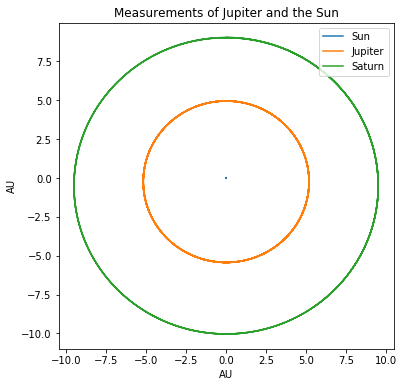

In [9]:
print('num_bodies:',num_bodies)

plt.figure(figsize=(6, 6))
ax3 = plt.subplot(111)
ax3.plot(positions[:,:,0],positions[:,:,1],'-')
ax3.set_title('Measurements of Jupiter and the Sun')
plt.legend(['Sun', "Jupiter", 'Saturn'], loc='upper right')

plt.xlabel("AU")
plt.ylabel("AU")

plt.savefig("x.png")

positions.shape

### Save generated data

The following code saves the data. It is saved as "x" and an abbreviation of positions, velocities and acceleration, to wherever this file is located on ones computer.

In [10]:
xpos = np.array([positions[:,0,0],positions[:,0,1],positions[:,1,0],positions[:,1,1]]) 
xpos = xpos.T
xvel = np.array([velocities[:,0,0],velocities[:,0,1],velocities[:,1,0],velocities[:,1,1]]) 
xvel = xvel.T
xacc = np.array([accelerations[:,0,0],accelerations[:,0,1],accelerations[:,1,0],accelerations[:,1,1]]) 
xacc = xacc.T

if num_bodies > 2:
    xpos = np.array([positions[:,0,0],positions[:,0,1],positions[:,1,0],positions[:,1,1],positions[:,2,0],positions[:,2,1]])
    xpos = xpos.T
    xvel = np.array([velocities[:,0,0],velocities[:,0,1],velocities[:,1,0],velocities[:,1,1],velocities[:,2,0],velocities[:,2,1]])
    xvel = xvel.T
    xacc = np.array([accelerations[:,0,0],accelerations[:,0,1],accelerations[:,1,0],accelerations[:,1,1],accelerations[:,2,0],accelerations[:,2,1]])
    xacc = xacc.T

np.save('xpos.npy', xpos)
np.save('xvel.npy', xvel)
np.save('xacc.npy', xacc)